In [1]:
import sys
sys.path.append('src')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from pathlib import Path
import typing

from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from timething import dataset, job, text, utils, align, prealign, viz  # type: ignore

# Aligning a 30 minute Podcast

We would like to be able to align real-world data. That means longer tracks, along with real transcriptions. We'll be working with a podcast here. First, the config:

In [4]:
metadata = Path("/Users/purzelrakete/src/scratch/keanu/text.csv")
cfg = utils.load_config("english")
ds = dataset.SpeechDataset(Path(metadata), cfg.sampling_rate)
device = "cpu"

The aligner:

In [5]:
aligner = align.Aligner.build(device, cfg)
loader = DataLoader(
    ds,
    batch_size=1,
    num_workers=1,
    collate_fn=dataset.collate_fn,
    shuffle=False,
)

Cleaner:

In [6]:
clean_text_fn = text.TextCleaner(cfg.language, aligner.vocab())

The data:

In [7]:
batch = next(iter(loader))
xs, ys, ys_original, ids = batch

We have around 30 minutes of audio:

In [8]:
n_seconds = len(xs.squeeze()) / cfg.sampling_rate
n_minutes = n_seconds / 60
f"{n_minutes:.2f} minutes of audio"

'27.87 minutes of audio'

In [9]:
def window(xs, offset_seconds, length_seconds, cfg):
    "A smaller window of audio snipped out of x"
    offset = cfg.sampling_rate * offset_seconds
    duration = cfg.sampling_rate * length_seconds
    return xs[:, :, offset:(offset+duration)]

offset_seconds = 100
length_seconds = 10
snippet = window(xs, offset_seconds, length_seconds, cfg)

Let's have a listen:

In [10]:
ipd.Audio(snippet.squeeze(), rate=cfg.sampling_rate)

In [11]:
logprobs = aligner.logp(snippet)
logprobs

/usr/local/Caskroom/miniforge/base/envs/timething/lib/python3.9/site-packages/transformers-4.4.2-py3.8.egg/transformers/models/wav2vec2/modeling_wav2vec2.py:704: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


tensor([[[-5.6265e-05, -2.7643e+01, -2.7783e+01,  ..., -1.7225e+01,
          -1.4140e+01, -1.5117e+01],
         [-1.7166e-05, -2.8684e+01, -2.8888e+01,  ..., -1.8057e+01,
          -1.4828e+01, -1.6212e+01],
         [-2.0504e-05, -2.7996e+01, -2.8195e+01,  ..., -1.7621e+01,
          -1.4389e+01, -1.5875e+01],
         ...,
         [-2.2005e+00, -2.0642e+01, -2.0548e+01,  ..., -1.1903e+01,
          -8.1333e+00, -1.2528e+01],
         [-3.5704e+00, -1.7441e+01, -1.7425e+01,  ..., -1.1034e+01,
          -8.6169e+00, -1.1998e+01],
         [-9.0763e+00, -1.7129e+01, -1.7280e+01,  ..., -1.1620e+01,
          -1.0576e+01, -1.3566e+01]]])

In [12]:
prediction = prealign.decode_best(logprobs, aligner.vocab())
transcript = ys[0]
prediction

'alex i think i have what is probably a pretty common keonarivs experience which is that icana took i '

In [13]:
n_chars = 80
matches = list(prealign.similarity(prediction, transcript, n_chars=n_chars))
matches

[(0, 20, 0.415929203539823)]

In [14]:
query, match, confidence = matches[0]
start_query = int(query * n_chars / 2)
end_query = start_query + n_chars
start_match = int(match * n_chars / 2)
end_match = start_match + n_chars

padding_chars = 20
query_window = prediction[start_query:end_query]
match_window = transcript[start_match:end_match]
expanded_match_window = transcript[max(0, start_match - padding_chars):(end_match + padding_chars)]

print("Query:")
print(query_window)
print()

print("Match:")
print(expanded_match_window)
print()

Query:
alex i think i have what is probably a pretty common keonarivs experience which 

Match:
e star who appears to give us so little.  Alex, I think I have what is probably a pretty common Keanu Reeves experience,



In [15]:
recording = dataset.Recording(
    f"keanu-{offset_seconds}:{length_seconds}", 
    snippet[0], 
    clean_text_fn(expanded_match_window), 
    expanded_match_window, 
    None, 
    cfg.sampling_rate
)

batch = dataset.collate_fn([recording])
xs, ys, ys_original, ids = batch
alignments = aligner.align((xs, ys, ys_original))
alignment = alignments[0]


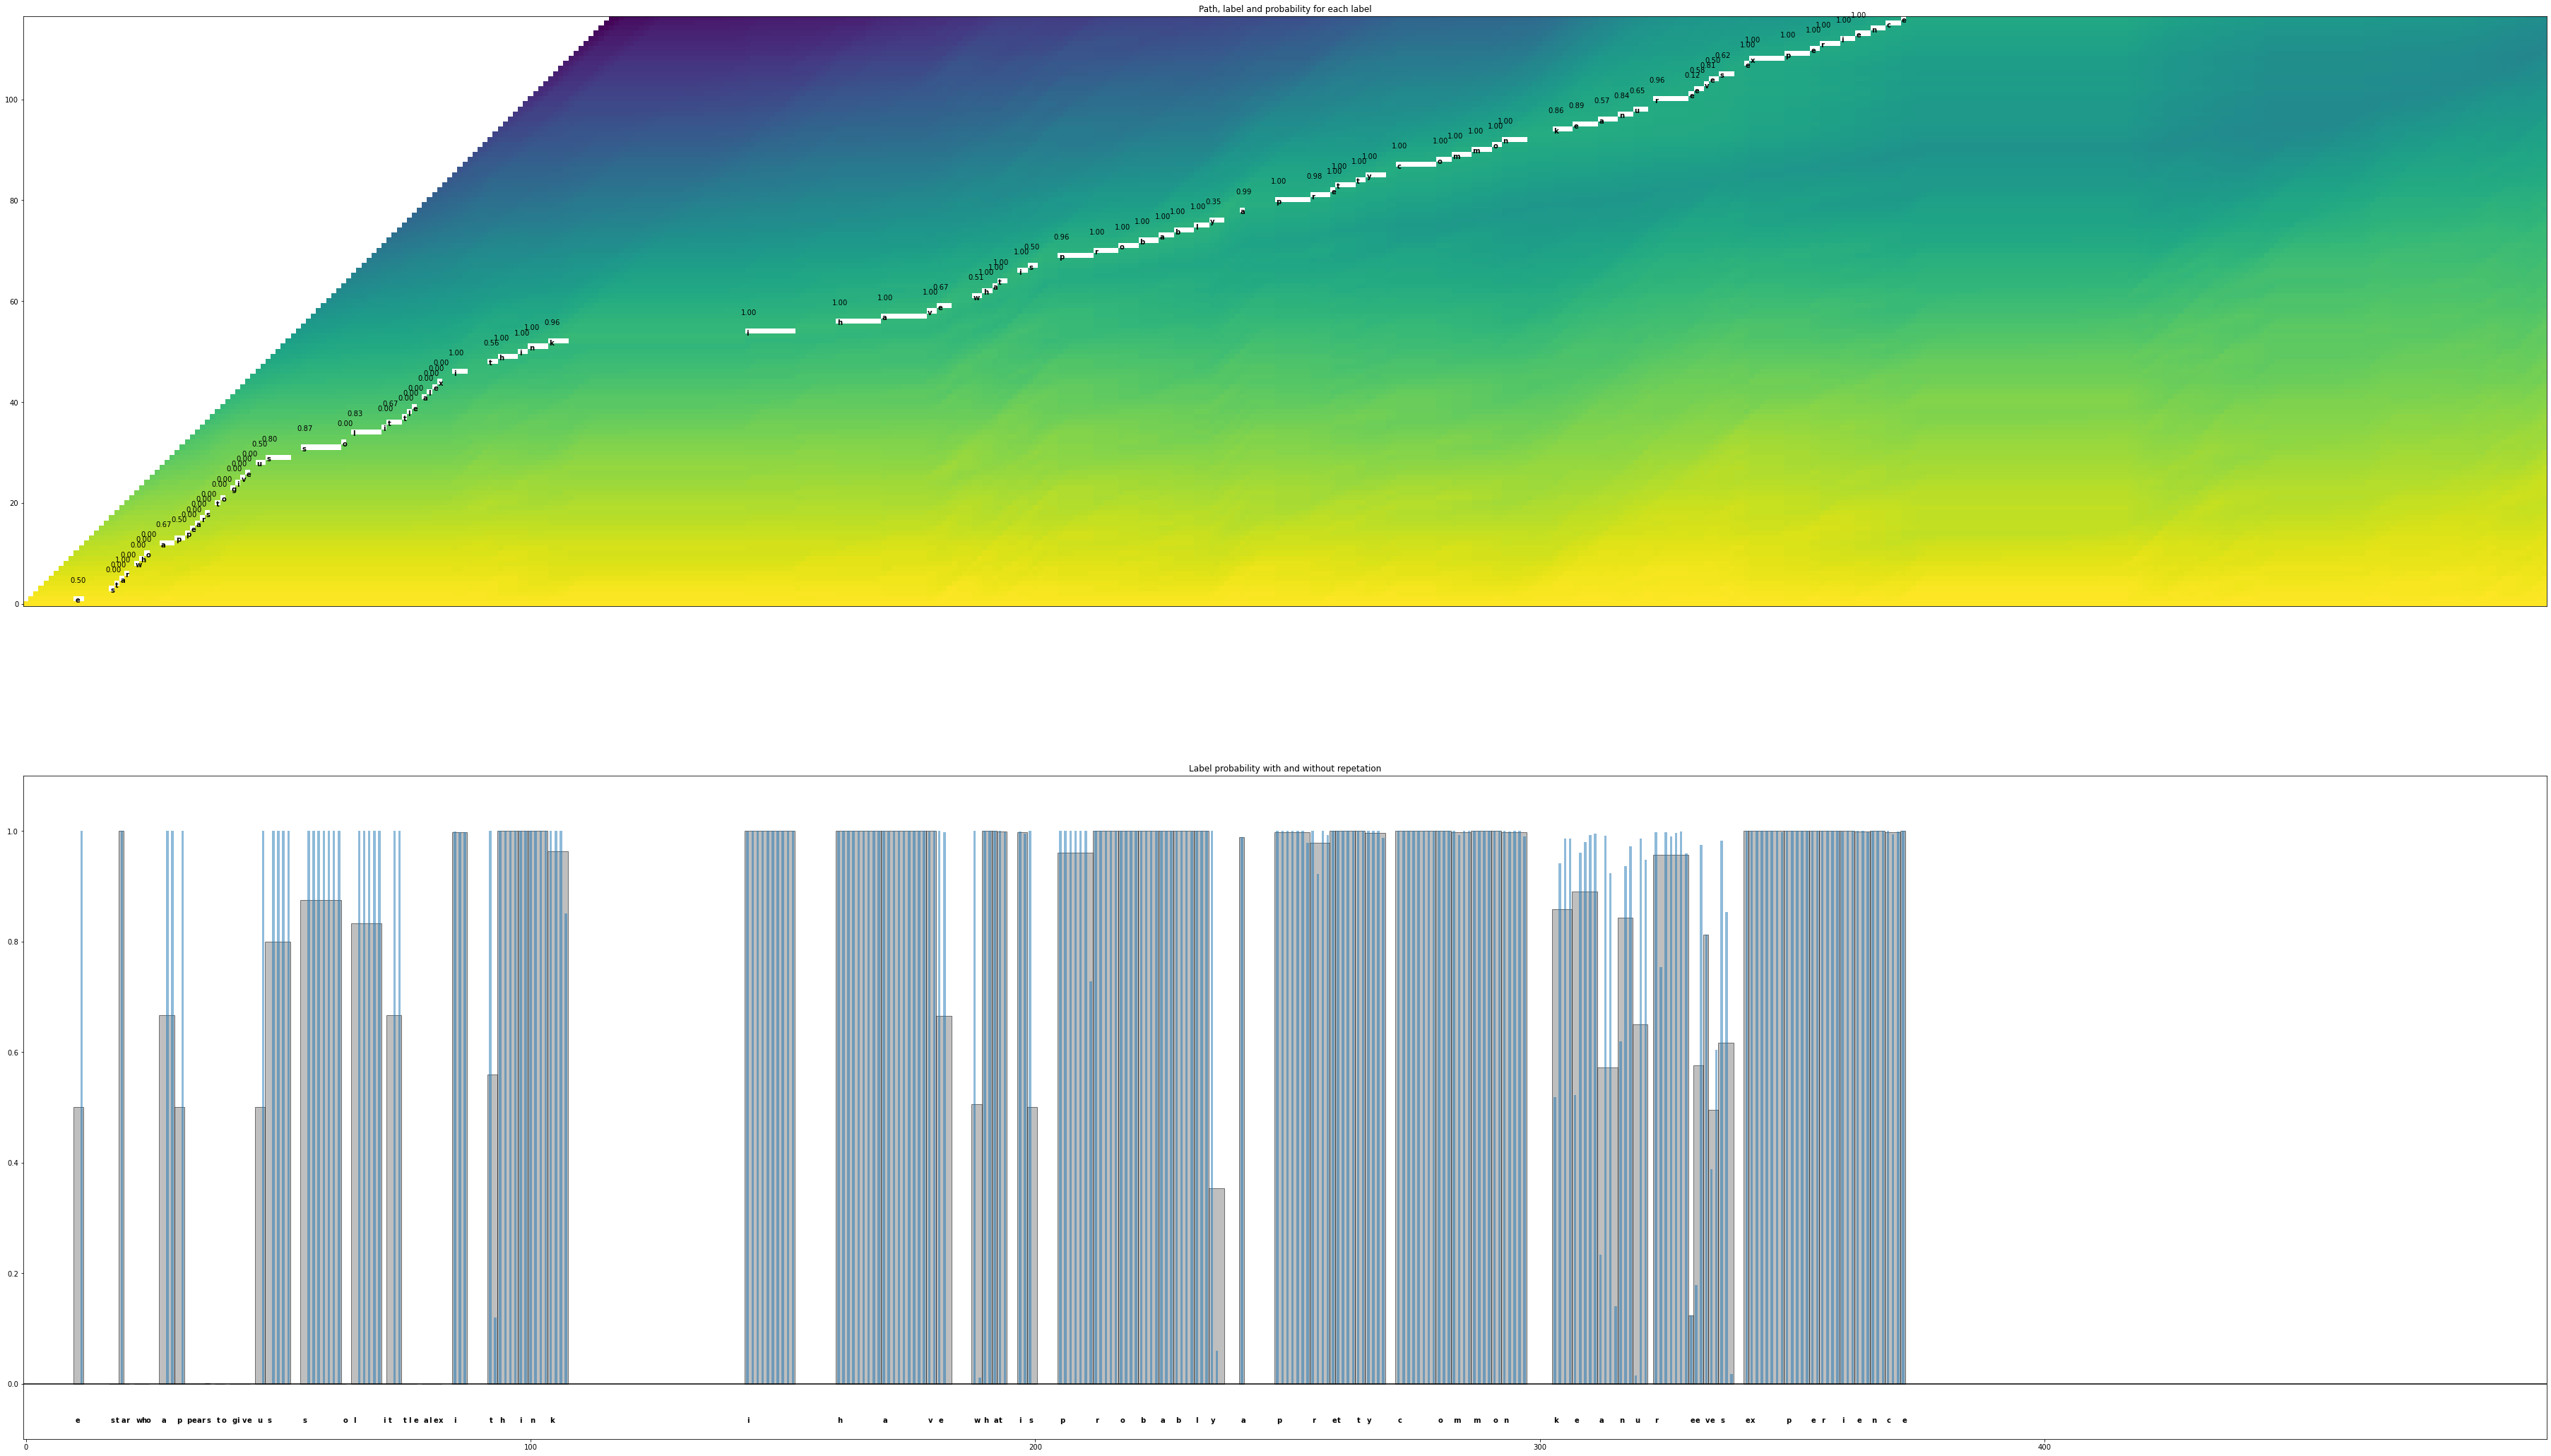

In [16]:
viz.plot_trellis_with_segments(alignment.trellis, alignment.chars_cleaned, ys[0], alignment.path);

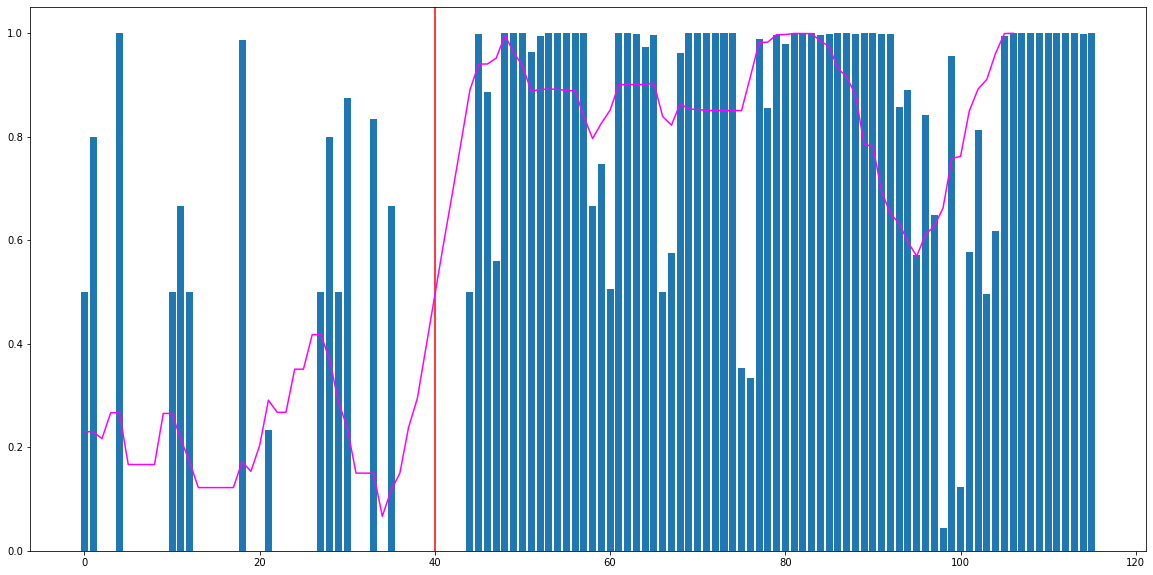

In [17]:
scores = [s.score for s in alignment.chars_cleaned]
i_start_word = [s.label for s in alignment.words_cleaned].index("alex")
frame_start = alignment.words_cleaned[i_start_word].start
i_start_char = [s.start for s in alignment.chars_cleaned].index(frame_start)

w = 10
smoothed = np.convolve(scores, np.ones(w), 'valid') / w

plt.figure(figsize=(20, 10))
plt.bar(range(len(scores)), scores)
plt.axvline(x=i_start_char, color='red')
plt.plot(smoothed, color="magenta")


In [18]:
start_seconds = alignment.model_frames_to_seconds(0) + offset_seconds
end_seconds = alignment.model_frames_to_seconds(106) + offset_seconds
y, sr = utils.load_slice(metadata.parent / 'keanu.mp3', start_seconds, end_seconds)
ipd.display(ipd.Audio(y, rate=sr))

In [24]:
for w in alignment.words_cleaned:
    if w.score > 0.75:
        print(w.label)
    else:
        print('.')

.
.
.
.
.
.
.
.
.
.
i
think
i
have
what
.
probably
a
pretty
common
.
reeves
experience
